<a href="https://colab.research.google.com/github/Harshilpatel2605/Fruit-Ripeness-Classifier/blob/main/fruit_ripeness_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Ripeness Classifier - CNN

In [77]:
# ignore python warnings, tensorflow logs
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Mount Google Drive

In [78]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
DATASET_PATH = '/content/dataset'
MODEL_PATH = '/content/fruit_ripeness_model.h5'

In [80]:
# Download & unzip dataset

if not os.path.exists(DATASET_PATH):
    print("Downloading dataset...")
    !kaggle datasets download -d leftin/fruit-ripeness-unripe-ripe-and-rotten -q
    !unzip -q -o fruit-ripeness-unripe-ripe-and-rotten.zip -d {DATASET_PATH}
else:
    print("Dataset already exists, skipping download.")


Dataset already exists, skipping download.


In [81]:
# Setup GPU strategy
import tensorflow as tf

strategy = tf.distribute.get_strategy()  # Automatically uses GPU if available
print("Using default strategy (GPU/CPU if available)")
print("REPLICAS: ", strategy.num_replicas_in_sync)

Using default strategy (GPU/CPU if available)
REPLICAS:  1


### Data Pre-processing

Classes: ['unripe apple', 'unripe banana', 'unripe orange', 'freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


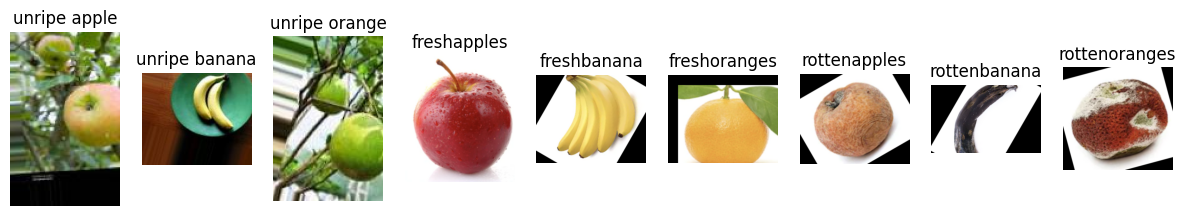

In [82]:
# Pre-process Data

from keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (100,100)
BATCH_SIZE = 128
DATASET_TRAIN_PATH = os.path.join(DATASET_PATH, 'fruit_ripeness_dataset/archive (1)/dataset')

# Get classes
train_path = os.path.join(DATASET_TRAIN_PATH, 'train')
classes = ['unripe apple', 'unripe banana', 'unripe orange',
                 'freshapples', 'freshbanana', 'freshoranges',
                 'rottenapples', 'rottenbanana', 'rottenoranges']
print("Classes:", classes)

# Display one sample image per class
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(15,5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_path, cls)
    img_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    img_file = random.choice(img_files)
    img_path = os.path.join(cls_path, img_file)
    img = mpimg.imread(img_path)
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

###Train Model


In [83]:
from tensorflow.keras.models import load_model
import shutil

# Paths
RAW_TRAIN_PATH = '/content/dataset/fruit_ripeness_dataset/archive (1)/dataset/train'
CLEAN_TRAIN_PATH = '/content/dataset/clean_train'
MODEL_PATH = '/content/fruit_ripeness_model.h5'

# Desired class order
classes = ['unripe apple', 'unripe banana', 'unripe orange',
           'freshapples', 'freshbanana', 'freshoranges',
           'rottenapples', 'rottenbanana', 'rottenoranges']

# Clean dataset: copy only required classes and ignore duplicates
os.makedirs(CLEAN_TRAIN_PATH, exist_ok=True)
for cls in classes:
    src = os.path.join(RAW_TRAIN_PATH, cls)
    dst = os.path.join(CLEAN_TRAIN_PATH, cls)
    if os.path.exists(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)

# Check if training is needed
train_needed = not os.path.exists(MODEL_PATH)

if train_needed:
    print("No saved model found. Preparing datasets and training...")

    # Prepare datasets
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        CLEAN_TRAIN_PATH,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(100,100),
        batch_size=128,
        class_names=classes
    )

    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        CLEAN_TRAIN_PATH,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(100,100),
        batch_size=128,
        class_names=classes
    )

    # Normalize
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

    # Build CNN inside strategy.scope
    with strategy.scope():
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(len(classes), activation='softmax')
        ])

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    model.summary()

    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=15
    )

    # Save model
    model.save(MODEL_PATH)
    print("Model trained and saved!")

else:
    print("Saved model found! Loading model...")
    model = load_model(MODEL_PATH)
    history = None  # dummy for plotting if needed

No saved model found. Preparing datasets and training...
Found 16217 files belonging to 9 classes.
Using 12974 files for training.
Found 16217 files belonging to 9 classes.
Using 3243 files for validation.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,937 (6.61 MB)

 Trainable params: 1,732,937 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 306ms/step - accuracy: 0.4803 - loss: 1.3467 - val_accuracy: 0.7582 - val_loss: 0.5992
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.7595 - loss: 0.6006 - val_accuracy: 0.7814 - val_loss: 0.5256
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - accuracy: 0.8080 - loss: 0.4731 - val_accuracy: 0.8023 - val_loss: 0.4678
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.8267 - loss: 0.4141 - val_accuracy: 0.8323 - val_loss: 0.4010
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.8654 - loss: 0.3319 - val_accuracy: 0.8270 - val_loss: 0.4155
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.8797 - loss: 0.2999 - val_accuracy: 0.8532 - val_loss: 0.3711
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.8981 - loss: 0.2536 - val_accuracy: 0.8566 - val_loss: 0.3769
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - accuracy: 0.9276 - loss: 0

Model trained and saved!


### Accuracy Graph

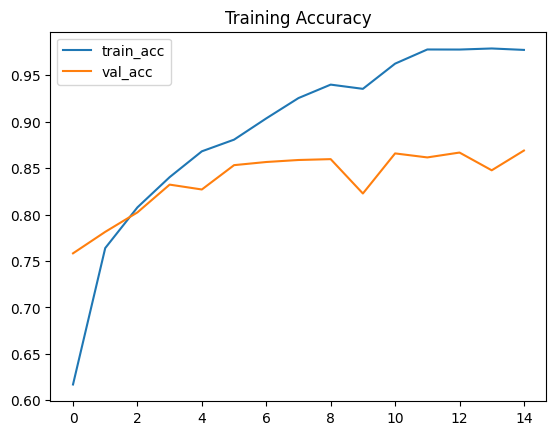

Final Training Accuracy: 97.73%
Final Validation Accuracy: 86.89%


In [88]:
import matplotlib.pyplot as plt
import numpy as np

if train_needed:
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Training Accuracy")
    plt.legend()
    plt.show()

    final_train_acc = history.history['accuracy'][-1] * 100
    final_val_acc   = history.history['val_accuracy'][-1] * 100
    print(f"Final Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")

else:
    # If model loaded, evaluate on validation set to plot accuracy
    val_dataset_eval = image_dataset_from_directory(
        DATASET_TRAIN_PATH,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_names=classes
    )
    val_dataset_eval = val_dataset_eval.map(lambda x, y: (x/255.0, y))
    loss, acc = model.evaluate(val_dataset_eval)
    acc_percent = acc * 100
    print(f"Validation Accuracy: {acc_percent:.2f}%")
    plt.bar(['Validation Accuracy'], [acc])
    plt.ylim(0,1)
    plt.show()


### Confusion Matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


<Figure size 1000x1000 with 0 Axes>

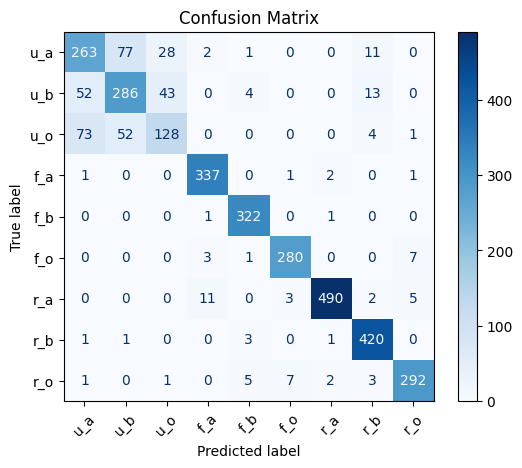

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

short_classes = [
    'u_a', 'u_b', 'u_o',   # unripe apple, banana, orange
    'f_a', 'f_b', 'f_o',   # fresh apple, banana, orange
    'r_a', 'r_b', 'r_o'    # rotten apple, banana, orange
]

# Generate predictions
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.argmax(axis=1))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_classes)
plt.figure(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

### Test Data Accuracy



In [86]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_TRAIN_PATH, "test"),
    image_size=(100,100),
    batch_size=64,
    class_names=classes
)

# Normalize test images
test_dataset = test_dataset.map(lambda x, y: (x/255.0, y))

# accuracy on test data
loss, acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {acc*100:.2f}%")

Found 3739 files belonging to 9 classes.
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9032 - loss: 0.3391
Test Accuracy: 89.70%


### Making Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


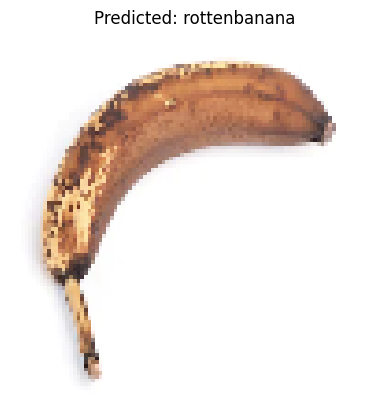

In [89]:
import random
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

TEST_PATH = RAW_TRAIN_PATH.replace("train", "test")

# Picking a random class
cls = random.choice(classes)
cls_path = os.path.join(TEST_PATH, cls)

# Picking a random image from that folder
img_file = random.choice(os.listdir(cls_path))
img_path = os.path.join(cls_path, img_file)

# Load & preprocess the image
img = image.load_img(img_path, target_size=(100,100))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
pred = model.predict(img_array)
pred_class = classes[np.argmax(pred)]

# Show the image with prediction
plt.imshow(img)
plt.title(f"Predicted: {pred_class}")
plt.axis("off")
plt.show()
